<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/torch/mnist_convert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 認識モデルを PyTorch で構築して変換

[公式サンプル](https://github.com/pytorch/examples/blob/main/mnist/main.py)をベースに実装

## 事前確認

バージョンチェック

In [1]:
import torch

print(f"torch.__version__={torch.__version__}")
print(f"torch.cuda.is_available()={torch.cuda.is_available()}\n")

print(f"torch.cuda.device_count()={torch.cuda.is_available()}")
print(f"torch.cuda.current_device()={torch.cuda.is_available()}")
print(f"torch.cuda.device(0)={torch.cuda.device(0)}\n")

if torch.cuda.is_available():
    print(f"torch.cuda.get_device_name(0)={torch.cuda.get_device_name(0)}")
    print(f"torch.cuda.get_device_capability()={torch.cuda.get_device_capability()}")

torch.__version__=2.1.0+cu118
torch.cuda.is_available()=True

torch.cuda.device_count()=True
torch.cuda.current_device()=True
torch.cuda.device(0)=<torch.cuda.device object at 0x7850f5862080>

torch.cuda.get_device_name(0)=Tesla T4
torch.cuda.get_device_capability()=(7, 5)


[使用するデバイスを確認](https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf)

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 12 15:55:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

seed の固定。deterministic は処理低下を起こすため注意。

In [3]:
import random
import numpy as np

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True

torch_fix_seed()

Tensorboard の用意

In [5]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

## データセットの用意

データの読み込み

In [6]:
%%capture
from torchvision import datasets, transforms

mean, scale = 0.1307, 0.3081
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (scale,))
])

dataset1 = datasets.MNIST(
    '../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(
    '../data', train=False, transform=transform)

データの可視化

dataset1_targets[0]=5
dataset1_data.shape=(60000, 28, 28)


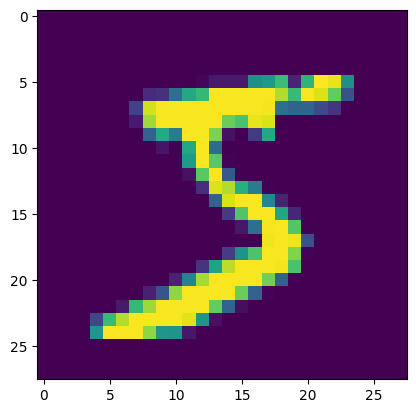

In [7]:
import matplotlib.pyplot as plt

dataset1_data = dataset1.data.numpy()
dataset1_targets = dataset1.targets.numpy()

print(f"dataset1_targets[0]={dataset1_targets[0]}")
print(f"dataset1_data.shape={dataset1_data.shape}")
img = dataset1_data[0]
plt.imshow(img)

データローダの作成。
[高速化のためのオプション](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)を設定。

In [ ]:
cuda_kwargs = {
    'num_workers': 2,
    'pin_memory': True,
    'shuffle': True
}

train_batch_size, test_batch_size = 64, 1000
train_kwargs = {'batch_size': train_batch_size}
test_kwargs = {'batch_size': test_batch_size}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## モデル作成

モデル定義

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

モデルのインスタンスを作成

In [ ]:
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Use device={device_str}")
device = torch.device(device_str)

model = Net().to(device)

単一データで推論する関数を定義。推論前に `model.eval()` が必要なことに注意。

In [ ]:
def single_inference(model, idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...].to(device)
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale

    print(f"input data shape = {img.shape}")

    # use inference mode
    # (otherwise 32 batch size needed)
    model.eval()
    with torch.no_grad():
        probs = model(img)

    # get highest probability
    inference = probs.argmax(dim=1, keepdim=True)[0, 0]
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

実際に推論。未学習なので不正解。

In [ ]:
single_inference(model, idx=0)

## 学習

最適化手法を定義

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

lr = 1.0
gamma = 0.7
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習方法を定義

In [ ]:
log_interval = 10
dry_run = False
amp_dtype = torch.float16 if device_str == "cuda" else torch.bfloat16

def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # AMP: Automatic Mixed Precision
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (data, target) in enumerate(train_loader):
        # data transfer
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # AMP: Automatic Mixed Precision
        with torch.amp.autocast(device_str, dtype=amp_dtype):
            # inference
            output = model(data)
            # nll = negative log likelihood loss
            loss = F.nll_loss(output, target)

        writer.add_scalar("Loss/train", loss, epoch)

        # back propagation
        scaler.scale(loss).backward()
        # gradient decent
        scaler.step(optimizer)
        # update scale
        scaler.update()

#        if batch_idx % log_interval != 0:
#            continue

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#            epoch, batch_idx * len(data), len(train_loader.dataset),
#            100. * batch_idx / len(train_loader), loss.item()))

#        if dry_run:
#            break

推論・バリデーション

In [ ]:
def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.3f}%)")

学習を実行

In [ ]:
from tqdm import tqdm

epochs = 14
for epoch in tqdm(range(1, epochs + 1)):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

writer.flush()

Tensorboard の起動。
Chrome との相性が悪いため [Tips](https://github.com/googlecolab/colabtools/issues/3990#issuecomment-1782676249) を利用。

In [ ]:
%%capture

%load_ext tensorboard
# Start tensorboard
# Please ignore the error page in the output and go to the next cell
%tensorboard --logdir ./logs --host=127.0.0.1 --port=6006 --load_fast=false

外部リンクから Tensorboard にアクセス

In [ ]:
# Access tensorboard via colab's proxy
# Click the link that appears in the output
from google.colab import output
output.serve_kernel_port_as_window(6006, path="")

モデルの保存。対象は元のモデル。

In [ ]:
torch.save(model.state_dict(), "mnist_cnn.pth")

## 推論

保存したモデルのロード

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load('mnist_cnn.pth'))

推論を実施

In [ ]:
single_inference(model, idx=0)

## 別形式への変換

[ここ](https://qiita.com/hirune924/items/06520f44927b0844a86c)を参照

### TorchScript

[Scripting による変換](https://rarejob-tech-dept.hatenablog.com/entry/2022/07/29/190000)

In [ ]:
script_model = torch.jit.script(model)
script_model.save("mnist_cnn_script.pth")
script_model = torch.jit.load("mnist_cnn_script.pth")
single_inference(script_model, idx=0)

### ONNX

[ここを参照](https://colab.research.google.com/drive/13CxIsi4CfV-Cn40B9xnAfka9NqzSjk84?usp=sharing)

torch.onnx の利用に onnx ライブラリが必要。
GPUでの実行は onnxruntime-gpu をインストール。

In [ ]:
%%capture
!pip install onnx
!pip install onnxruntime-gpu

ダミーの入力を利用して変換・出力

In [ ]:
def get_dummy_input(model, idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...].to(device)
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    return img

dummy_input = get_dummy_input(model, idx=0)
torch.onnx.export(model, dummy_input, "mnist_cnn.onnx", verbose=True,
                  # for ONNX -> TensorFlow
                  input_names=['input'], output_names=['output'])

[ロードしてモデルの確認](https://qiita.com/studio_haneya/items/be9bc7c56af44b7c1e0a#4-2-%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E6%BA%96%E5%82%99)

In [ ]:
import onnx

onnx_model = onnx.load("mnist_cnn.onnx")

onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

セッション作成

In [ ]:
import onnxruntime

sess = onnxruntime.InferenceSession(
    "mnist_cnn.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

[推論を実施](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/5_Deployment/5_4_super_resolution_with_onnxruntime_jp.ipynb#scrollTo=MRcd4bt0cnAt)

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def onnx_single_inference(idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...]
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    img = to_numpy(img)

    print(f"input data shape = {img.shape}")

    ort_inputs = {sess.get_inputs()[0].name: img}
    probs = sess.run(None, ort_inputs)

    # get highest probability
    inference = np.argmax(np.array(probs))
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

onnx_single_inference(idx=0)

### TensorFlow

[onnx-tensorflow](https://github.com/onnx/onnx-tensorflow) をインストール

In [ ]:
%%capture
!pip install onnx-tf

[ここ](https://colab.research.google.com/drive/13CxIsi4CfV-Cn40B9xnAfka9NqzSjk84?usp=sharing#scrollTo=_EH_Sd64nE9p)を参考にONNXのモデルを読み込み。
[ここ](https://github.com/onnx/onnx-tensorflow/blob/main/doc/API.md)からTFのモデルへ変換。

In [ ]:
from onnx_tf.backend import prepare

# onnx_tf.backend_rep.TensorflowRep
tf_rep_model = prepare(onnx_model)
# save TF model
tf_rep_model.export_graph("mnist_cnn_tf")

TensorflowRep のまま推論

In [ ]:
def tf_rep_single_inference(idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...]
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    img = to_numpy(img)

    print(f"input data shape = {img.shape}")

    probs = tf_rep_model.run(img)

    # get highest probability
    inference = np.argmax(np.array(probs))
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

tf_rep_single_inference(idx=0)

TenforFlow のモデルと推論機能を読み込み

In [ ]:
import tensorflow as tf

tf_model = tf.saved_model.load("mnist_cnn_tf")
infer = tf_model.signatures["serving_default"]

出力形式を確認しておく

In [ ]:
tf_infer = tf_model.signatures["serving_default"]
print(tf_infer.structured_outputs)

推論を実施

In [ ]:
def tf_single_inference(idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...]
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    img = to_numpy(img)

    print(f"input data shape = {img.shape}")

    output_name = tf_infer.structured_outputs["output"].name
    probs = tf_infer(tf.constant(img))[output_name]

    # get highest probability
    inference = np.argmax(np.array(probs))
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

tf_single_inference(idx=0)

### TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("mnist_cnn_tf")
tflite_model = converter.convert()
open("mnist_cnn.tflite", "wb").write(tflite_model)

[ここ](https://qiita.com/yohachi/items/434f0da356161e82c242)を参考にモデルの読み込み

In [ ]:
# TFLiteモデルの読み込み
tfl_model = tf.lite.Interpreter(model_path="mnist_cnn.tflite")
# メモリ確保。これはモデル読み込み直後に必須
tfl_model.allocate_tensors()

入力形式について確認

In [ ]:
tfl_model.get_input_details()

In [ ]:
def tfl_single_inference(idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...]
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    img = to_numpy(img)

    print(f"input data shape = {img.shape}")

    # indexにテンソルデータのポインタをセット
    input_details = tfl_model.get_input_details()
    tfl_model.set_tensor(input_details[0]['index'], img)

    # 推論実行
    tfl_model.invoke()

    # 推論結果は、output_detailsのindexに保存されている
    output_details = tfl_model.get_output_details()
    probs = tfl_model.get_tensor(output_details[0]['index'])

    # get highest probability
    inference = np.argmax(np.array(probs))
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")


tfl_single_inference(idx=0)

### OpenVINO

In [ ]:
%%capture
!pip install openvino
!pip install openvino-dev

PyTorch から OpenVINO のモデルへ変換

In [ ]:
from openvino.tools.mo import convert_model

ov_model = convert_model(model, example_input=dummy_input)

In [ ]:
import openvino as ov
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
print(device)

コンパイルを実施

In [ ]:
ov_compiled_model = core.compile_model(model=ov_model, device_name=device.value)

推論

In [ ]:
def ov_single_inference(idx):
    # slice only 1 data
    img = dataset1.data[[idx], ...]
    # add channel axis (size 1)
    img = img[:, None, ...]
    # normalization
    img = (img - mean) / scale
    img = to_numpy(img)

    print(f"input data shape = {img.shape}")

    probs = ov_compiled_model([img])[0]
    print(probs)

    # get highest probability
    inference = np.argmax(np.array(probs))
    answer = dataset1.targets[idx]

    print(f"inference={inference}")
    print(f"answer={answer}")

ov_single_inference(idx=0)

### MyriadX blob for OAK-D camera

In [ ]:
%%capture
!pip install blobconverter

[ここ](https://docs.luxonis.com/en/latest/pages/model_conversion/)に従って Web API で変換。
ローカルのコンパイルが必要な場合は[ここ](https://docs.luxonis.com/en/latest/pages/tutorials/local_convert_openvino/)を参照。

In [ ]:
import blobconverter

blob_path = blobconverter.from_onnx(
    model="mnist_cnn.onnx",
    data_type="FP16",
    shaves=5,
    optimizer_params=[
        "--input_shape=[1,1,28,28]",
    ]
)

In [ ]:
blob_path